In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from imblearn.over_sampling import RandomOverSampler

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

In [62]:
# load dataset
from google.colab import drive

drive.mount('/drive')
data = pd.read_csv('/drive/My Drive/Colab Notebooks/Cervical Cancer.csv')
data.head()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [63]:
data = data.replace('?', np.nan)

In [64]:
data = data.apply(pd.to_numeric, axis=0)

In [65]:
# Generating list of categorical factors:
temp=data.drop(columns=['Biopsy']).nunique()
cat=temp.loc[temp.values < 4].index.to_list()

# Updating null values to the most dominant category:
for factor in cat:
    data[factor] = data[factor].fillna(1)

In [66]:
# Generating list of non-categorical factors:
temp=data.drop(columns=['Biopsy']).nunique()
non_cat=temp.loc[temp.values > 3].index.to_list()

# Implementing interpolation (with linear method), on known data for null values:
for factor in non_cat:
  if (factor == ('STDs: Time since first diagnosis') or factor == ('STDs: Time since last diagnosis')):
    data[factor] = data[factor].fillna(data[factor].median())
  else:
    data[factor]=data[factor].interpolate(method='linear')

In [67]:
y = data['Biopsy']
X = data.drop('Biopsy',axis=1)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)

In [69]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
X_train = minmax_scale.fit_transform(X_train)
X_val = minmax_scale.fit_transform(X_val)
X_test = minmax_scale.fit_transform(X_test)

In [70]:
from tensorflow.keras import initializers
initializer = tf.keras.initializers.HeNormal(seed=0)

model = Sequential(
    [
        Dense(32, activation = 'relu', input_shape=[35], kernel_initializer=initializer),
        Dense(16, activation = 'relu', kernel_initializer=initializer),
        Dense(8, activation = 'relu', kernel_initializer=initializer),
        Dense(4, activation = 'relu', kernel_initializer=initializer),
        Dense(1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    ]
)

In [71]:
model.build()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1152      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,857
Trainable params: 1,857
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, 
                        epochs=150, batch_size=32,
                        validation_data=(X_val, y_val), 
                        shuffle=True)

Epoch 1/150
17/17 [==============================] - 1s 14ms/step - loss: 0.6809 - accuracy: 0.7023 - val_loss: 0.6687 - val_accuracy: 0.8198
Epoch 2/150
17/17 [==============================] - 0s 5ms/step - loss: 0.6713 - accuracy: 0.8268 - val_loss: 0.6593 - val_accuracy: 0.9128
Epoch 3/150
17/17 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.9047 - val_loss: 0.6499 - val_accuracy: 0.9244
Epoch 4/150
17/17 [==============================] - 0s 5ms/step - loss: 0.6504 - accuracy: 0.9066 - val_loss: 0.6396 - val_accuracy: 0.9244
Epoch 5/150
17/17 [==============================] - 0s 5ms/step - loss: 0.6388 - accuracy: 0.9144 - val_loss: 0.6284 - val_accuracy: 0.9360
Epoch 6/150
17/17 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.9319 - val_loss: 0.6154 - val_accuracy: 0.9302
Epoch 7/150
17/17 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.9339 - val_loss: 0.6023 - val_accuracy: 0.9302
Epoch 8/150


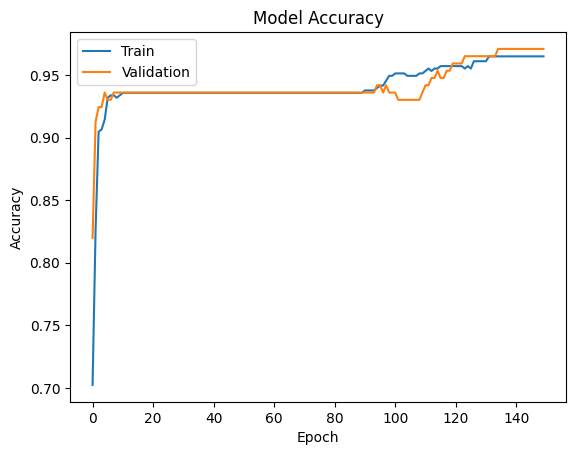

In [73]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='upper left')

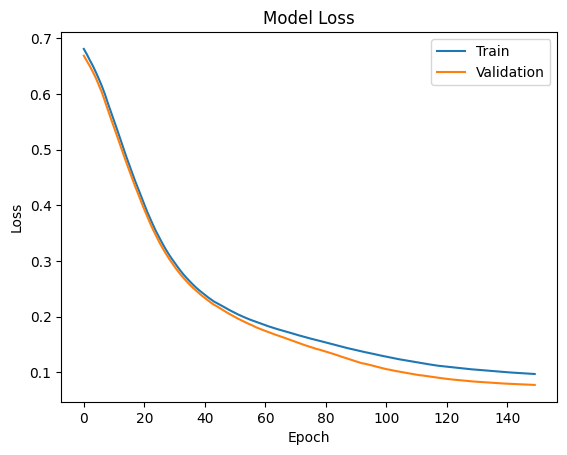

In [74]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

In [120]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

6/6 [==============================] - 0s 3ms/step - loss: 0.1400 - accuracy: 0.9535
Test loss: 0.14004087448120117
Test accuracy: 0.9534883499145508


In [121]:
prediction = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [122]:
data_ans = pd.DataFrame({'Biopsy' :y_test})
data_ans['Prediction'] = np.round_(prediction)

In [123]:
data_ans

,Biopsy,Prediction
713,0,0.0
604,0,0.0
120,0,0.0
208,0,0.0
380,0,0.0
...,...,...
610,1,1.0
235,0,0.0
333,0,0.0
215,0,0.0


In [124]:
data_ans[data_ans['Biopsy'] != data_ans['Prediction']]

,Biopsy,Prediction
23,1,0.0
704,0,1.0
227,0,1.0
377,1,0.0
275,0,1.0
687,1,0.0
753,1,0.0
411,0,1.0


In [104]:
data_ans['Prediction'].value_counts()

0.0    161
1.0     11
Name: Prediction, dtype: int64

In [105]:
data_ans['Biopsy'].value_counts()

0    161
1     11
Name: Biopsy, dtype: int64

6/6 [==============================] - 0s 2ms/step

Confusion Matrix


Text(50.722222222222214, 0.5, 'True')

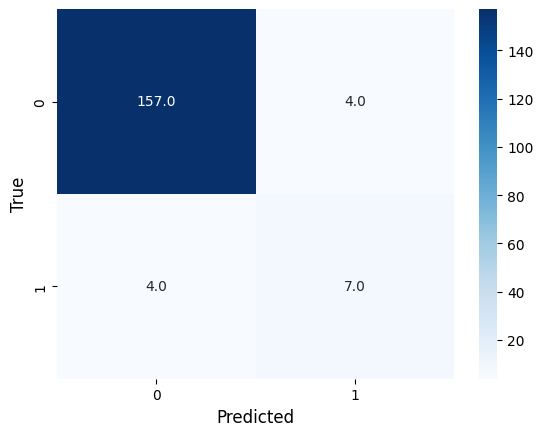

In [108]:
from sklearn.metrics import precision_recall_fscore_support
y_true = y_test
y_pred = model.predict(X_test)

# Make the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(np.round_(y_true), np.round_(y_pred))
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = ".1f" )
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [116]:
print(classification_report(np.round_(y_true),np.round_(y_pred)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       161
           1       0.64      0.64      0.64        11

    accuracy                           0.95       172
   macro avg       0.81      0.81      0.81       172
weighted avg       0.95      0.95      0.95       172



In [111]:
print(model.trainable_variables) 

[<tf.Variable 'dense_15/kernel:0' shape=(35, 32) dtype=float32, numpy=
array([[-0.39646775, -0.18243872, -0.23124786, ...,  0.23832975,
         0.01703444,  0.24194553],
       [ 0.30696884, -0.4051976 , -0.07834373, ..., -0.31045043,
         0.37527305, -0.48295003],
       [ 0.02751844,  0.25490656,  0.25228393, ..., -0.2702271 ,
         0.24313758, -0.04577189],
       ...,
       [-0.48219892, -0.1610781 ,  0.44581565, ..., -0.12160721,
         0.16118304,  0.03237481],
       [-0.39159155, -0.34967113, -0.508761  , ..., -0.40453166,
         0.5773201 ,  0.1642428 ],
       [-0.22106604,  0.23673473, -0.01845114, ..., -0.2186211 ,
         0.05304373,  0.10436219]], dtype=float32)>, <tf.Variable 'dense_15/bias:0' shape=(32,) dtype=float32, numpy=
array([ 0.086653  , -0.03117102, -0.06168848, -0.06589296, -0.07343485,
        0.08459612,  0.07289849, -0.07014773, -0.04058735, -0.01646656,
        0.19045596,  0.01883662,  0.02836936, -0.01312324, -0.06390081,
        0.08940387

In [112]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [113]:
model.save('my_model.h5')

In [114]:
from google.colab import files

files.download('saved_model/my_model/variables/variables.data-00000-of-00001')
files.download('saved_model/my_model/variables/variables.index')
files.download('saved_model/my_model/fingerprint.pb')
files.download('saved_model/my_model/keras_metadata.pb')
files.download('saved_model/my_model/saved_model.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [117]:
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [119]:
loss, acc = new_model.evaluate(X_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

6/6 [==============================] - 0s 3ms/step - loss: 0.1400 - accuracy: 0.9535
Restored model, accuracy: 95.35%
